In [15]:
#Pkg.update("JLD")
using JLD
include("fld_with_parameters.jl")
using PyPlot
using CSV

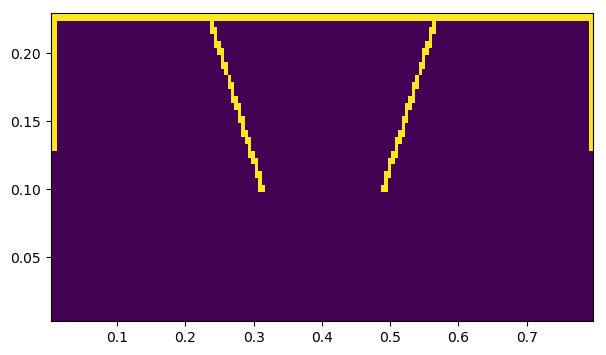

Running until time 0.5
Size of domain in Z is 1


PyObject <matplotlib.collections.QuadMesh object at 0x000000002464D860>

In [16]:
tfinal = .5
Lr = .29
Lz = 1
Nr = 58
Nz = 200
scale = .8
r_apt = 1
sc_length = 1
theta = 30

println("Running until time $(tfinal)")
println("Size of domain in Z is $(Lz)")

function scale_change(scale,Lr,Lz,Nr,Nz)
    Lz = Lz*scale
    Lr = Lr*scale
    Nr = round(Int,Nr*scale)
    Nz = round(Int,Nz*scale)
    T = zeros(Nr*Nz)+1e-3
    return Lz,Lr,Nr,Nz,T
end


function sigma_func_hohlraum(t,T,Nr,Nz,Lr,Lz,scale,r_apt,sc_length,theta)
    T_sigma = reshape(T,Nr,Nz)
    sigma = zeros(Nr,Nz) + 0.8732390148206142*T_sigma.^(-3.5)
    dr = Lr/Nr
    dz = Lz/Nz
    rcenter = linspace(0.5*dr, Lr-0.5*dr, Nr)
    zcenter = linspace(0.5*dz, Lz-0.5*dz, Nz)
    
    theta_rad = (theta/180)*pi
    a_side = (.29-.12)
    b = a_side*tan(theta_rad)
    arm_start = (.2-b)
    arm_end = arm_start + 0.01
    Nr_start = round(Int,((.12*r_apt*scale*sc_length)/dr))
    Nr_end =  round(Int,((.276*scale)/dz))
    Nr_diff = Nr_end - Nr_start
    scale_denom = b/Nr_diff
    scale_num = dr
    diagonal_scale = scale_num/scale_denom
    for i in 1:Nr
        for j in 1:Nz
            if ((rcenter[i] + dr*.5)<(.12*r_apt*scale*sc_length))
                sigma[i,j] = 0.01*20
            elseif ((abs(zcenter[j]-(.5*scale))<(arm_start*scale*sc_length))) & ((rcenter[i] + dr*.5)<(.276*scale)) 
                sigma[i,j] = 0.01*20
            elseif ((abs(zcenter[j]-(.5*scale))>(.21*scale*sc_length))) & ((abs(zcenter[j]-(.5*scale))<(.485*scale))) & ((rcenter[i] + dr*.5)<(.276*scale))
                sigma[i,j] = 0.01*20
            elseif ((abs(zcenter[j]-(.5*scale))>=(.485*scale))) & ((rcenter[i] + dr*.5)<(.16*scale)) 
                sigma[i,j] = 0.01*20
            end         
    
        end
    end
    if theta > 0
        for q in Nr_start:Nr_end
            for z in 1:Nz
                if ((abs(zcenter[z]-(.5*scale)))>=(arm_end*sc_length*scale)) & ((abs(zcenter[z]-(.5*scale))<(.485*scale)))
                    sigma[q,z] = 0.01*20
                elseif ((abs(zcenter[z]-(.5*scale)))<=(arm_start*sc_length*scale))
                    sigma[q,z] = 0.01*20
                end
             end
            arm_end = arm_end + dz/(diagonal_scale)
            arm_start = arm_start + dz/(diagonal_scale)
        end
    
    end
    sigma
end

function Cv_func(t,T,Nr,Nz,Lr,Lz)
    cv = zeros(Nr,Nz) + 10*0.05
    dr = Lr/Nr
    dz = Lz/Nz
    rcenter = linspace(0.5*dr, Lr-0.5*dr, Nr)
    zcenter = linspace(0.5*dz, Lz-0.5*dz, Nz)
    for i in 1:Nr
        for j in 1:Nz
            if ((rcenter[i] + dr*0.5) < 0.5) & (abs(zcenter[j] - 3.5) >=0.5)
                cv[i,j] = 0.01*0.05
            elseif ((rcenter[i] + dr*0.5) < 1.5) & (abs(zcenter[j] - 2.75) <=0.25)
                cv[i,j] = 0.01*0.05
            elseif ((rcenter[i] + dr*0.5) < 1.5) & (abs(zcenter[j] - 4.25) <=0.25)
                cv[i,j] = 0.01*0.05
            elseif  ((rcenter[i] + dr*0.5)  < 1.5) & (rcenter[i] - dr*0.5  > 1.0) & (abs(zcenter[j] - 3.5) <= 1.0)
                cv[i,j] = 0.01*0.05
            end
        end
    end
    cv                 
end

function D_func(t,T,Nr,Nz,Lr,Lz,Er_tmp,sigma) 
    #larsen n=2 flux limiter
    Er = reshape(T,Nr,Nz)
    idz = Nz/Lz
    idr = Nr/Lr
    D = zeros(Nr,Nz) 
    for i in 1:Nr
        for j in 1:Nz
            gradE = zeros(2)
            if (i > 1)
                gradE[1] += (Er[i,j]-Er[i-1,j])*idr*0.5
            end
            if (i < Nr)
                gradE[1] += (Er[i+1,j]-Er[i,j])*idr*0.5
            end
            if (j > 1)
                gradE[2] += (Er[i,j]-Er[i,j-1])*idz*0.5
            end
            if (j < Nz)
                gradE[2] += (Er[i,j+1]-Er[i,j])*idz*0.5
            end
            normGradE = sqrt(gradE[1]^2 + gradE[2]^2)/(Er[i,j] + 1e-12)
            
            D[i,j] = 1.0./sqrt( (3.0*sigma[i,j])^2 + normGradE^2)
        end
    end
    D
end

function EOS(t,T,Nr,Nz,Lr,Lz)
    T_tmp = reshape(T,Nr,Nz)
    E = zeros(Nr,Nz) + T_tmp*(10*0.05)
    dr = Lr/Nr
    dz = Lz/Nz
    rcenter = linspace(0.5*dr, Lr-0.5*dr, Nr)
    zcenter = linspace(0.5*dz, Lz-0.5*dz, Nz)
    for i in 1:Nr
        for j in 1:Nz
            if ((rcenter[i] + dr*0.5) < 0.5) & (abs(zcenter[j] - 3.5) >=0.5)
                E[i,j] = T_tmp[i,j]*(0.01*0.05)
            elseif ((rcenter[i] + dr*0.5) < 1.5) & (abs(zcenter[j] - 2.75) <=0.25)
                E[i,j] = T_tmp[i,j]*(0.01*0.05)
            elseif ((rcenter[i] + dr*0.5) < 1.5) & (abs(zcenter[j] - 4.25) <=0.25)
                E[i,j] = T_tmp[i,j]*(0.01*0.05)
            elseif ( (rcenter[i] + dr*0.5  < 1.5) & (rcenter[i] - dr*0.5  > 1.0)) & (abs(zcenter[j] - 3.5) <= 1.0) 
                E[i,j] = T_tmp[i,j]*(0.01*0.05)
            end
        end
    end
    reshape(E,Nr*Nz)                 
end

function invEOS(t,T,Nr,Nz,Lr,Lz)
    E_tmp = reshape(T,Nr,Nz)
    T = zeros(Nr,Nz) + E_tmp/(10*0.05)
    dr = Lr/Nr
    dz = Lz/Nz
    rcenter = linspace(0.5*dr, Lr-0.5*dr, Nr)
    zcenter = linspace(0.5*dz, Lz-0.5*dz, Nz)
    for i in 1:Nr
        for j in 1:Nz
            if ((rcenter[i] + dr*0.5) < 0.5) & (abs(zcenter[j] - 3.5) >=0.5)
                T[i,j] = E_tmp[i,j]/(0.01*0.05)
            elseif ((rcenter[i] + dr*0.5) < 1.0) & (abs(zcenter[j] - 2.75) <=0.25)
                T[i,j] = E_tmp[i,j]/(0.01*0.05)
            elseif ((rcenter[i] + dr*0.5) < 1.0) & (abs(zcenter[j] - 4.25) <=0.25)
                T[i,j] = E_tmp[i,j]/(0.01*0.05)
            elseif  (rcenter[i] + dr*0.5  < 1.5) & (rcenter[i] - dr*0.5  > 1.0) & (abs(zcenter[j] - 3.5) <= 1.0)
                T[i,j] = E_tmp[i,j]/(0.01*0.05)
            end
        end
    end
    reshape(T,Nr*Nz)                 
end

function Q_func(t,T,Nr,Nz,Lr,Lz,scale)
    Q = zeros(Nr,Nz)
    dr = Lr/Nr
    dz = Lz/Nz
    rcenter = linspace(0.5*dr, Lr-0.5*dr, Nr)
    zcenter = linspace(0.5*dz, Lz-0.5*dz, Nz)

    # keep radiation sources on for 2.5 nanoseconds because that is how long the laser is on for 
    if t <= .25
     for i in 1:Nr
        for j in 1:Nz
            if ((abs(zcenter[j]-(.5*scale)))>(.25*scale*sc_length)) & ((abs(zcenter[j]-(.5*scale)))<=((.3*scale*sc_length))) & ((rcenter[i] + dr*.5)>((.276+dr)*scale)) 
                # got Q value by taking 250 KJ/10^-8seconds (from graph of laser pulse) and dividing by the volume for the 
                #radiation sources and making it in units of gigajoule/cm^3/10^-8seconds volume = .002
                height = (.3-.25)*scale
                volume_cylinder = 2*pi*(height)*((.29*scale)^2-((.276+dr)*scale)^2)
                Q[i,j] = 250/(10^5*volume_cylinder)
              
            end
        end
      end
    else
        Q = zeros(Nr,Nz)
    end
    Q
end


Lz,Lr,Nr,Nz,T = scale_change(scale,Lr,Lz,Nr,Nz)
sig = sigma_func_hohlraum(0,T,Nr,Nz,Lr,Lz,scale,r_apt,sc_length,theta)
dr = Lr/Nr
dz = Lz/Nz
rcenter = linspace(0.5*dr, Lr-0.5*dr, Nr)
zcenter = linspace(0.5*dz, Lz-0.5*dz, Nz)
R,Z = meshgrid(rcenter,zcenter)
#sig2 = Q_func(0,T,Nr,Nz,Lr,Lz,scale)

figure(figsize=(7,4))
#pcolormesh(Z,R,(sig-sig2./(10.0^-12)))
pcolormesh(Z,R,sig)




In [17]:
tfinal = .5
Lr = .29
Lz = 1
Nr = 58
Nz = 200
dt = 0.005
times, Er_t,T_t,Nr,Nz,Lr,Lz = time_dep_RT(tfinal,dt,scale_change,D_func, sigma_func_hohlraum,scale,r_apt,sc_length,Q_func,Cv_func,EOS,invEOS,
                      Nr, Nz, Lr, Lz, theta, lower_z="vacuum", upper_z="vacuum", upper_r="refl",LOUD=-1,
    fname="crooked_pipe$(r_apt)_$(sc_length)_$(scale)_$(theta).jld");

dr = Lr/Nr
dz = Lz/Nz

101
Step 100, t = 0.5


0.005

In [41]:
#Tr_plot = reshape((Er_t[:,size(times)[1]]/a).^.25,Nr,Nz)
#println(size(Tr_plot))
#figure(figsize=(7,4))
#pcolormesh(Z,R,Tr_plot)
#colorbar()
#axis("scaled")

#T_plot = reshape(T_t[:,size(times)[1]],Nr,Nz)
#figure(figsize=(7,4))
#pcolormesh(Z,R,T_plot)
#colorbar()
#ylim(0,4)
#xlim(0,7)
#axis("scaled")

In [14]:
function Dante(r_apt,sc_length,scale,theta)
    Lr = .29
    Lz = 1
    Nr = 58
    Nz = 200
    Lz,Lr,Nr,Nz,T = scale_change(scale,Lr,Lz,Nr,Nz)
    d_half = load("crooked_pipe$(r_apt)_$(sc_length)_$(scale)_$(theta).jld", "Er")
    Dante_Temperature = zeros(100)
    for z in 1:100
        Er_half = d_half[:,z]
        T_half = (Er_half/a).^.25
    
        T_plot = reshape(T_half,Nr,Nz)
        Temperatures_1 = zeros(0)
        Temperatures_2 = zeros(0)
        Temperatures_3 = zeros(0)
        Temperatures_4 = zeros(0)
        Temperatures_5 = zeros(0)
        Temperatures_6 = zeros(0)
        Temperatures_7 = zeros(0)
        Temperatures_8 = zeros(0)
        Temperatures_9 = zeros(0)
        Temperatures_10 = zeros(0)
  
        for i in 1:Nr
            for j in 1:Nz
                if ((rcenter[i] + dr*0.5) < 0.005) & (abs(zcenter[j] - (.5*scale)) <= 0.05 )
                    append!(Temperatures_1, T_plot[i,j])
                elseif ((rcenter[i] + dr*0.5) < 0.01) & (abs(zcenter[j] - (.5*scale)) <= 0.05 )
                    append!(Temperatures_2, T_plot[i,j])
                elseif ((rcenter[i] + dr*0.5) <= 0.015) & (abs(zcenter[j] - (.5*scale)) <= 0.05 )
                    append!(Temperatures_3, T_plot[i,j])
                elseif ((rcenter[i] + dr*0.5) < 0.02) & (abs(zcenter[j] - (.5*scale)) <= 0.05 )
                    append!(Temperatures_4, T_plot[i,j])
                elseif ((rcenter[i] + dr*0.5) < 0.025) & (abs(zcenter[j] - (.5*scale)) <= 0.05 )
                    append!(Temperatures_5, T_plot[i,j])
                elseif ((rcenter[i] + dr*0.5) < 0.03) & (abs(zcenter[j] - (.5*scale)) <= 0.05 )
                    append!(Temperatures_6, T_plot[i,j])
                elseif ((rcenter[i] + dr*0.5) < 0.035) & (abs(zcenter[j] - (.5*scale)) <= 0.05 )
                    append!(Temperatures_7, T_plot[i,j])
                elseif ((rcenter[i] + dr*0.5) <= 0.04) & (abs(zcenter[j] - (.5*scale)) <= 0.05 )
                    append!(Temperatures_8, T_plot[i,j])
                elseif ((rcenter[i] + dr*0.5) <= 0.045) & (abs(zcenter[j] - (.5*scale)) <= 0.05 )
                    append!(Temperatures_9, T_plot[i,j])
                elseif ((rcenter[i] + dr*0.5) < 0.05) & (abs(zcenter[j] - (.5*scale)) <= 0.05 )
                    append!(Temperatures_10, T_plot[i,j])
                end
            end
        end
        #Temp_ave_1  = sum(Temperatures_1)/length(Temperatures_1)
        Temp_ave_2  = sum(Temperatures_2)/length(Temperatures_2)
        Temp_ave_3  = sum(Temperatures_3)/length(Temperatures_3)
        Temp_ave_4  = sum(Temperatures_4)/length(Temperatures_4)
        Temp_ave_5  = sum(Temperatures_5)/length(Temperatures_5)
        Temp_ave_6  = sum(Temperatures_6)/length(Temperatures_6)
        Temp_ave_7  = sum(Temperatures_7)/length(Temperatures_7)
        Temp_ave_8  = sum(Temperatures_8)/length(Temperatures_8)
        Temp_ave_9  = sum(Temperatures_9)/length(Temperatures_9)
        Temp_ave_10  = sum(Temperatures_10)/length(Temperatures_10)
    
        #Temp_1 = Temp_ave_1*(0.01*0.005^2*pi)/(0.01*0.05^2*pi)
        Temp_2 = Temp_ave_2*(0.01*(0.01^2-0.005^2)*pi)/(0.01*0.05^2*pi)
        Temp_3 = Temp_ave_3*(0.01*(0.015^2-0.01^2)*pi)/(0.01*0.05^2*pi)
        Temp_4 = Temp_ave_4*(0.01*(0.02^2-0.015^2)*pi)/(0.01*0.05^2*pi)
        Temp_5 = Temp_ave_5*(0.01*(0.025^2-0.02^2)*pi)/(0.01*0.05^2*pi)
        Temp_6 = Temp_ave_6*(0.01*(0.03^2-0.025^2)*pi)/(0.01*0.05^2*pi)
        Temp_7 = Temp_ave_7*(0.01*(0.035^2-0.03^2)*pi)/(0.01*0.05^2*pi)
        Temp_8 = Temp_ave_8*(0.01*(0.04^2-0.035^2)*pi)/(0.01*0.05^2*pi)
        Temp_9 = Temp_ave_9*(0.01*(0.045^2-0.04^2)*pi)/(0.01*0.05^2*pi)
        Temp_10 = Temp_ave_10*(0.01*(0.05^2-0.045^2)*pi)/(0.01*0.05^2*pi)

        Dante_Temperature[z] =Temp_2+Temp_3+Temp_4+Temp_5+Temp_6+Temp_7+Temp_8+Temp_9+Temp_10

    end
    Dante_Temperature
end




Dante (generic function with 1 method)

In [ ]:
#Dante_1_1_1_0 = Dante(r_apt,sc_length,scale,theta)

#Time = linspace(0,.5,100)
#plot(Time,Dante_1_1_1_0)
#title("Dante Temperature")
#xlabel("time (sh)")
#ylabel("T_rad")

In [ ]:
#Time = linspace(0,.5,100)
#plot(Time,Dante_Temperature_0,label=("Theata = 0"))
#plot(Time,Dante_Temperature,label=("Theata = 15"))
#plot(Time,Dante_Temperature_30,label=("Theata = 30"))
#title("Dante Temperature")
#legend(loc = "best")
#xlabel("time (sh)")
#ylabel("T_rad")

#println("The max Dante Temeperature when theta = 0 is ", maximum(Dante_Temperature_0))
#println("The max Dante Temeperature when theta = 15 is ", maximum(Dante_Temperature))
#println("The max Dante Temeperature when theta = 30 is ", maximum(Dante_Temperature_30))

In [ ]:
#using PyPlot
#using PyCall
#@pyimport matplotlib.animation as anim

##Construct Figure and Plot Data

#fig = figure("MyFigure",figsize=(7,2))
#ax = axes(xlim = (0,1),ylim=(0,.29))

## Define the init function, which draws the first frame (empty, in this case)
#function init()
#    Lr = .29
#    Lz = 1
#    Nr = 58
#    Nz = 200
#    Lz,Lr,Nr,Nz = scale_change(scale,Lr,Lz,Nr,Nz)
#    dt = 0.005
#    d_half = load("crooked_pipe$(r_apt)_$(sc_length)_$(scale)_$(theta).jld", "Er");
#    time_shown = (0)*dt
#    Er_half = d_half[:,1]
#    T_half = (Er_half/a).^.25
#    T_plot = reshape(T_half,Nr,Nz)
#    title("Time = $(time_shown)")
#    pcolormesh(T_plot,vmin=0, vmax=.27)
#    colorbar()
#    #axis("scaled") 
#end


## Animate draws the i-th frame, where i starts at i=0 as in Python.
#function animate(t)
#    Lr = .29
#    Lz = 1
#    Nr = 58
#    Nz = 200
#    dt = 0.005
#    Lz,Lr,Nr,Nz = scale_change(scale,Lr,Lz,Nr,Nz)
#    d_half = load("crooked_pipe$(r_apt)_$(sc_length)_$(scale)_$(theta).jld", "Er");
#    time_shown = (t+1)*dt
#    Er_half = d_half[:,t+2]
#    T_half = (Er_half/a).^.25
#    T_plot = reshape(T_half,Nr,Nz)
#    title("Time = $(time_shown)")
#    pcolormesh(T_plot,vmin=0, vmax=.27)
#    axis("scaled") 
#end

## Create the animation object by calling the Python function FuncAnimaton
#myanim = anim.FuncAnimation(fig, animate, init_func=init, frames=100, interval=200)

## Convert it to an MP4 movie file and saved on disk in this format.
##myanim[:save]("3Lines.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
#myanim[:save]("DiffusionTest.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
    
## Function for creating an embedded video given a filename
#function html_video(filename)
#    open(filename) do f
#        base64_video = base64encode(f)
#        """<video controls src="data:video/x-m4v;base64,$base64_video">"""
#    end
#end

## Display the movie in a Julia cell as follows. Note it has animation controls for the user.
##display("text/html", html_video("3Lines.mp4"))
#display("text/html", html_video("DiffusionTest.mp4"));

In [ ]:
for i in 1:100
    time_shown = (i-1)*dt
    Er_half = d_half[:,i]
    T_half = (Er_half/a).^.25
    T_plot = reshape(T_half,Nr,Nz)
    figure(figsize=(6,2))
    title("Time = $(time_shown)")
    pcolormesh(T_plot,vmin=0, vmax=.30)
    colorbar()
    axis("scaled")
end
    

## Vary Scale 

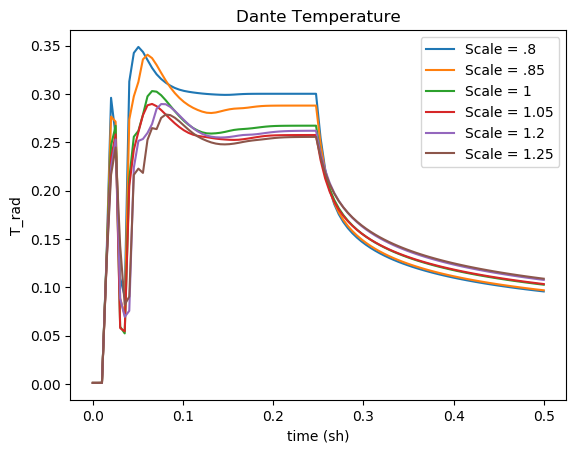

PyObject <matplotlib.legend.Legend object at 0x000000003CA30F60>

In [73]:
r_apt =1
sc_length = 1
theta = 0 


scale = .8
Dante_1_1_8_0 = Dante(r_apt,sc_length,scale,theta)
scale = .85
Dante_1_1_85_0 = Dante(r_apt,sc_length,scale,theta)
scale = 1
Dante_1_1_1_0 = Dante(r_apt,sc_length,scale,theta)
scale = 1.05
Dante_1_1_105_0 = Dante(r_apt,sc_length,scale,theta)
scale = 1.2
Dante_1_1_12_0 = Dante(r_apt,sc_length,scale,theta)
scale = 1.25
Dante_1_1_125_0 = Dante(r_apt,sc_length,scale,theta)

Time = linspace(0,.5,100)
plot(Time,Dante_1_1_8_0,label=("Scale = .8"))
plot(Time,Dante_1_1_85_0,label=("Scale = .85"))
plot(Time,Dante_1_1_1_0,label=("Scale = 1"))
plot(Time,Dante_1_1_105_0,label=("Scale = 1.05"))
plot(Time,Dante_1_1_12_0,label=("Scale = 1.2"))
plot(Time,Dante_1_1_125_0,label=("Scale = 1.25"))

title("Dante Temperature")
xlabel("time (sh)")
ylabel("T_rad")
legend(loc = "best")


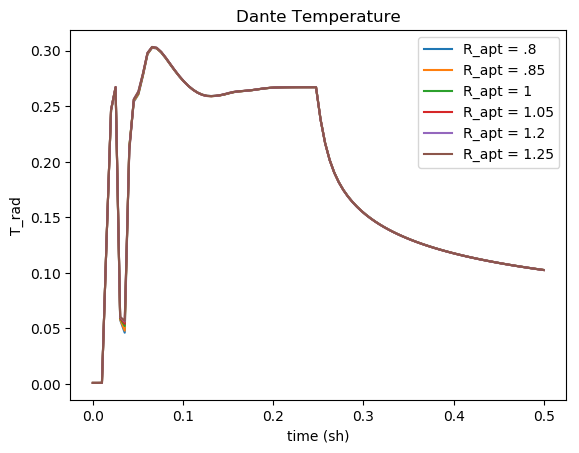

PyObject <matplotlib.legend.Legend object at 0x000000003E10B4E0>

In [95]:
scale =1
sc_length = 1
theta = 0 

r_apt =.8
Dante_8_1_1_0 = Dante(r_apt,sc_length,scale,theta)
r_apt =.85
Dante_85_1_1_0 = Dante(r_apt,sc_length,scale,theta)
r_apt =1
Dante_1_1_1_0 = Dante(r_apt,sc_length,scale,theta)
r_apt =1.05
Dante_105_1_1_0 = Dante(r_apt,sc_length,scale,theta)
r_apt =1.2
Dante_12_1_1_0 = Dante(r_apt,sc_length,scale,theta)
r_apt =1.25
Dante_125_1_1_0 = Dante(r_apt,sc_length,scale,theta)

Time = linspace(0,.5,100)
plot(Time,Dante_8_1_1_0,label=("R_apt = .8"))
plot(Time,Dante_85_1_1_0,label=("R_apt = .85"))
plot(Time,Dante_1_1_1_0,label=("R_apt = 1"))
plot(Time,Dante_105_1_1_0,label=("R_apt = 1.05"))
plot(Time,Dante_12_1_1_0,label=("R_apt = 1.2"))
plot(Time,Dante_125_1_1_0,label=("R_apt = 1.25"))

title("Dante Temperature")
xlabel("time (sh)")
ylabel("T_rad")
legend(loc = "best")


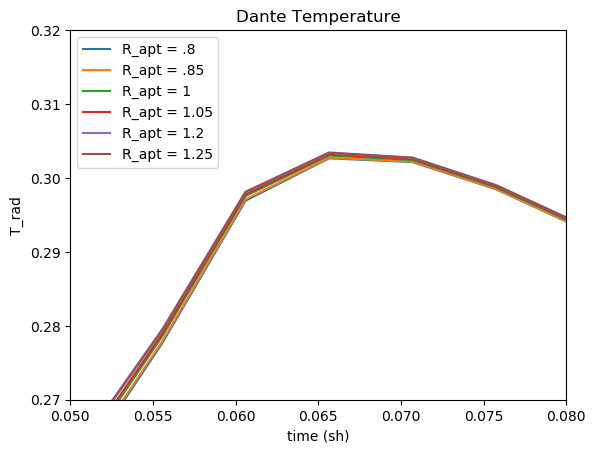

PyObject <matplotlib.legend.Legend object at 0x000000003E224940>

In [98]:

Time = linspace(0,.5,100)
plot(Time,Dante_8_1_1_0,label=("R_apt = .8"))
plot(Time,Dante_85_1_1_0,label=("R_apt = .85"))
plot(Time,Dante_1_1_1_0,label=("R_apt = 1"))
plot(Time,Dante_105_1_1_0,label=("R_apt = 1.05"))
plot(Time,Dante_12_1_1_0,label=("R_apt = 1.2"))
plot(Time,Dante_125_1_1_0,label=("R_apt = 1.25"))

title("Dante Temperature")
ylim(.27,.32)
xlim(.05,.08)
xlabel("time (sh)")
ylabel("T_rad")
legend(loc = "best")

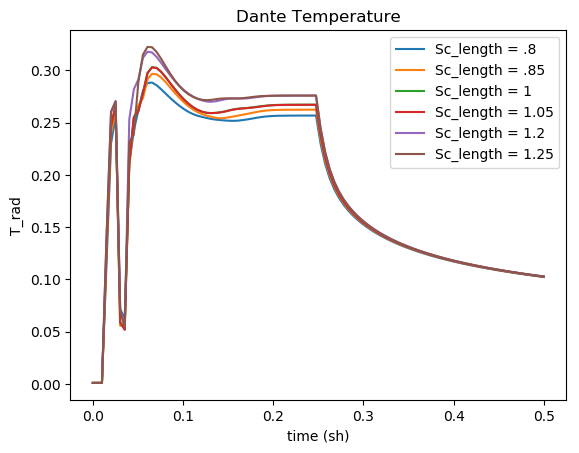

PyObject <matplotlib.legend.Legend object at 0x000000002264E470>

In [112]:
scale =1
r_apt = 1
theta = 0 

sc_length =.8
Dante_1_8_1_0 = Dante(r_apt,sc_length,scale,theta)
sc_length =.85
Dante_1_85_1_0 = Dante(r_apt,sc_length,scale,theta)
sc_length =1
Dante_1_1_1_0 = Dante(r_apt,sc_length,scale,theta)
sc_length =1.05
Dante_1_105_1_0 = Dante(r_apt,sc_length,scale,theta)
sc_length =1.2
Dante_1_12_1_0 = Dante(r_apt,sc_length,scale,theta)
sc_length =1.25
Dante_1_125_1_0 = Dante(r_apt,sc_length,scale,theta)

Time = linspace(0,.5,100)
plot(Time,Dante_1_8_1_0,label=("Sc_length = .8"))
plot(Time,Dante_1_85_1_0,label=("Sc_length = .85"))
plot(Time,Dante_1_1_1_0,label=("Sc_length = 1"))
plot(Time,Dante_1_105_1_0,label=("Sc_length = 1.05"))
plot(Time,Dante_1_12_1_0,label=("Sc_length = 1.2"))
plot(Time,Dante_1_125_1_0,label=("Sc_length = 1.25"))

title("Dante Temperature")
xlabel("time (sh)")
ylabel("T_rad")
legend(loc = "best")
